Dentro de vs_release_16k.zip descomprimimos dos carpetas:  
- audio_16k  
- meta  

Nos servimos del módulo zipfile para descomprimir y adicionalmente del módulo concurrent para utilizar threads agilizando la descompresión.  
https://superfastpython.com/multithreaded-unzip-files/#Unzip_Files_Concurrently_with_Processes

In [6]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

def unzip_file(handle, filename, path):
    handle.extract(path=path, member=filename)

output_dir = "data"
zip_filename = "vs_release_16k.zip"
dirs_to_extract = ["audio_16k", "meta"]

if not os.path.exists(output_dir):
    try:
        with ZipFile(zip_filename, 'r') as zf:
            filenames = zf.namelist()

            files_to_extract = [
                file for file in filenames
                if any(file.startswith(dir) for dir in dirs_to_extract)
            ]

            with ThreadPoolExecutor() as exe:
                for file in files_to_extract:
                    exe.submit(unzip_file, zf, file, output_dir)
    except:
        raise FileNotFoundError

print(os.listdir(output_dir))

['audio_16k', 'meta']


Ahora pasamos los datos a numpy arrays para poder trabajar con ellos:

In [7]:
import os
import wave
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor

def read_wav_file(wav_file):
    with wave.open(wav_file, 'rb') as wf:
        num_frames = wf.getnframes()
        frames = wf.readframes(num_frames)
        wave_array = np.frombuffer(frames, dtype=np.int16)
        wave_name = os.path.basename(wav_file)
        wave_name = os.path.splitext(wave_name)[0]
    return wave_name, wave_array

base_dir = "data"
dir = "audio_16k"

audio_dir = os.path.join(base_dir, dir)
audios = os.listdir(audio_dir)
audio_paths = [os.path.join(audio_dir, file) for file in audios]

with ThreadPoolExecutor() as exe:
    results = list(exe.map(read_wav_file, audio_paths))

results[0:5]

[('f0003_0_cough', array([38, 53, 50, ..., 19, 16,  9], dtype=int16)),
 ('f0003_0_laughter', array([-29,  71, 161, ..., 769, 860, 898], dtype=int16)),
 ('f0003_0_sigh', array([15, 49, 19, ..., 10, 10, 15], dtype=int16)),
 ('f0003_0_sneeze', array([ 49,  16, -69, ...,  -4,   1,   6], dtype=int16)),
 ('f0003_0_sniff', array([-37, -64, -58, ...,  21,  26,  24], dtype=int16))]

In [8]:
import os
import wave
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor

def read_wav_file(wav_file):
    with wave.open(wav_file, 'rb') as wf:
        num_frames = wf.getnframes()
        frames = wf.readframes(num_frames)
        wave_array = np.frombuffer(frames, dtype=np.int16)
        wave_name = os.path.basename(wav_file)
        wave_name = os.path.splitext(wave_name)[0]
    return wave_name, wave_array

base_dir = "data"
dir = "audio_16k"

audio_dir = os.path.join(base_dir, dir)
audios = os.listdir(audio_dir)
audio_paths = [os.path.join(audio_dir, file) for file in audios]

with ThreadPoolExecutor() as exe:
    results = list(exe.map(read_wav_file, audio_paths))

results[0:5]

[('f0003_0_cough', array([38, 53, 50, ..., 19, 16,  9], dtype=int16)),
 ('f0003_0_laughter', array([-29,  71, 161, ..., 769, 860, 898], dtype=int16)),
 ('f0003_0_sigh', array([15, 49, 19, ..., 10, 10, 15], dtype=int16)),
 ('f0003_0_sneeze', array([ 49,  16, -69, ...,  -4,   1,   6], dtype=int16)),
 ('f0003_0_sniff', array([-37, -64, -58, ...,  21,  26,  24], dtype=int16))]

Observación: Nuestros threadings acceden a elementos distintos por tanto no hay problemas de race condition.

f0003_0_cough.wav  
f -> female  
(o -> old? check transcripted)  
cough -> one of the 6 labels  
0 -> index of that cough (individuals may have more than 1 cough registered)

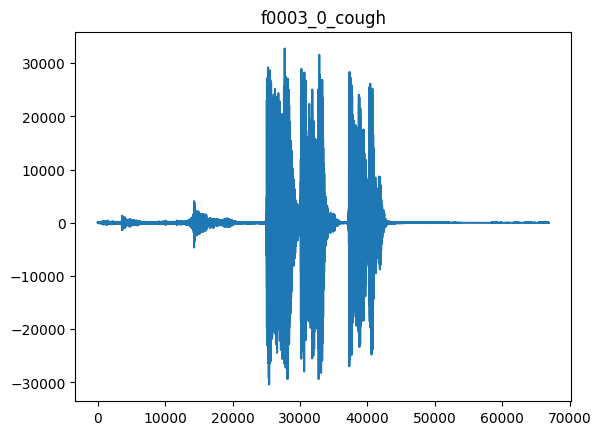

In [9]:
import matplotlib.pyplot as plt
name, arr = results[0]
plt.plot(arr)
plt.title(name)
plt.show()

In [10]:
import pandas as pd
import numpy as np

# Extraer información de cada registro
def extraer_informacion(registro):
    id_y_clase = registro[0].split('_')
    id = id_y_clase[0][1:]  # Eliminar el primer carácter y tomar el resto como ID
    sex = 'female' if id_y_clase[0][0] == 'f' else ('male' if id_y_clase[0][0] == 'm' else 'other')
    clase = id_y_clase[-1]  # La clase es el último elemento después de dividir por '_'
    return id, sex, clase, registro[1]

# Crear una lista de diccionarios para cada registro
datos_procesados = [{
    "id": extraer_informacion(registro)[0],
    "sex": extraer_informacion(registro)[1],
    "class": extraer_informacion(registro)[2],
    "data": extraer_informacion(registro)[3]
} for registro in results]

# Crear el DataFrame de Pandas
df = pd.DataFrame(datos_procesados)
# Añadir la columna 'index' que simplemente es el índice del DataFrame
df.reset_index(inplace=True)
df

,index,id,sex,class,data
0,0,0003,female,cough,"[38, 53, 50, 49, -6, -15, -26, -32, -6, -1, 36..."
1,1,0003,female,laughter,"[-29, 71, 161, 211, 192, 49, -13, -173, -207, ..."
2,2,0003,female,sigh,"[15, 49, 19, 22, -14, -19, 13, -13, 24, 12, 24..."
3,3,0003,female,sneeze,"[49, 16, -69, 146, -76, 132, -22, 86, 66, 6, 6..."
4,4,0003,female,sniff,"[-37, -64, -58, -72, -70, -68, -66, -70, -68, ..."
...,...,...,...,...,...
21019,21019,3362,other,laughter,"[41, 164, 17, 111, 44, -48, -50, 49, 27, -111,..."
21020,21020,3362,other,sigh,"[-1, -2, -2, -1, 0, -1, -1, -2, -1, -2, -1, 0,..."
21021,21021,3362,other,sneeze,"[909, 3041, 3134, 2094, -591, -1005, -1713, -6..."
21022,21022,3362,other,sniff,"[12, -233, -60, -95, -65, 180, -86, -94, -101,..."


A continuación aplicaremos la transformada de Fourier, esta es una herramienta matemática que descompone una señal en una combinación de funciones sinusoidales. En el caso de señales de audio, descompone la señal en sus componentes de frecuencia,esto permite visualizar las diferentes frecuencias presentes en la señal de audio y analizar su distribución de energía en el dominio de la frecuencia.

A partir de estas diferentes frecuencias, podemos identificar frecuencias dominantes, para filtrar y extraer los sonidos más característicos( y por tanto los que nos vayan a proprocionar información).

Al aplicar este proceso, buscamos obtener una representación más limpia y enfocada del sonido de interés, lo que nos permitirá mejorar el rendimiento de los modelos de clasificación que utilicemos más adelante. Al aislar las características acústicas relevantes de la tos, risa u otros eventos, esperamos que el modelo de clasificación pueda aprender de manera más efectiva las características distintivas de cada clase y, por lo tanto, hacer predicciones más precisas.

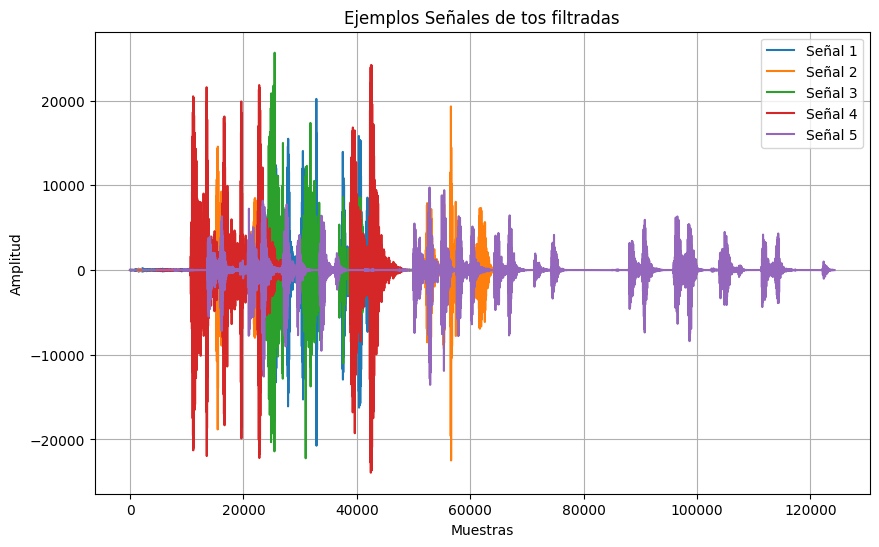

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter  # Importar lfilter

# Función para filtrar la señal en el dominio del tiempo
def filtrar_señal(signal, sample_rate, frecuencias_interes):
    # Filtro pasa banda Butterworth
    nyquist = 0.5 * sample_rate
    normal_frequencies = [f / nyquist for f in frecuencias_interes]
    b, a = butter(N=4, Wn=normal_frequencies, btype='bandpass')
    # Aplicar el filtro
    signal_filtrada = lfilter(b, a, signal)  # Utilizar lfilter
    return signal_filtrada

# Suponiendo que conoces la tasa de muestreo (sample rate) de tus datos de audio (por ejemplo, 16 kHz)
sample_rate = 16000

# Frecuencias relevantes asociadas con el sonido de la tos (puedes ajustar estos valores según sea necesario)
frecuencias_tos = [100, 400]

# Filtrar todas las señales identificadas como tos en el DataFrame
signals_tos_filtradas = []

for index, row in df[df['class'] == 'cough'].iterrows():
    signal = row['data']
    signal_tos_filtrada = filtrar_señal(signal, sample_rate, frecuencias_tos)
    signals_tos_filtradas.append(signal_tos_filtrada)

# Convertir la lista de señales filtradas en un DataFrame de Pandas
df_tos_filtrada = pd.DataFrame({'data': signals_tos_filtradas})

# Graficar algunas de las señales filtradas
plt.figure(figsize=(10, 6))
for i in range(5):  # Graficar las primeras 5 señales filtradas
    plt.plot(df_tos_filtrada.iloc[i]['data'], label=f'Señal {i+1}')
plt.title('Ejemplos Señales de tos filtradas')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()





Ejemplo de como era un sonido original en comparación con el nuevo sonido filtrado

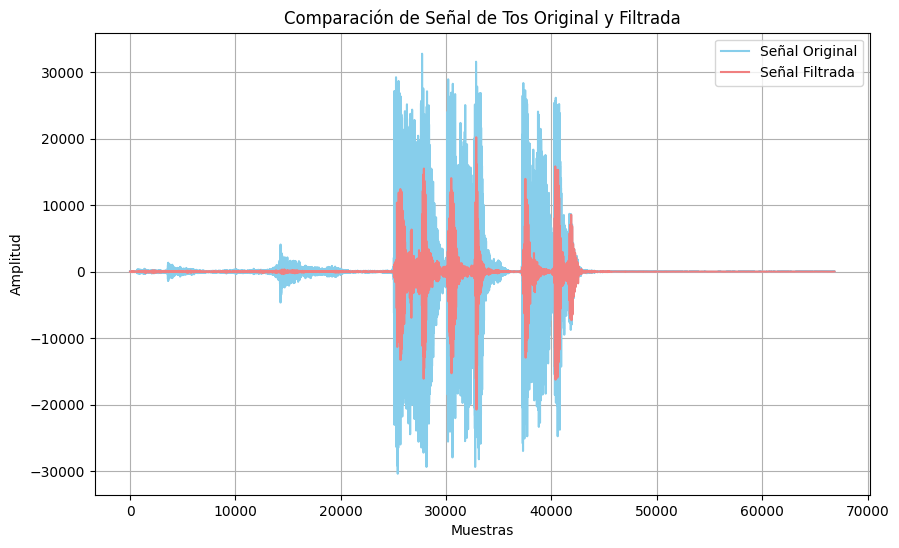

In [31]:
# Obtener la primera señal original y su versión filtrada
signal_original = df[df['class'] == 'cough']['data'].iloc[0]
signal_filtrada = df_tos_filtrada.iloc[0]['data']

# Graficar la primera señal original y su versión filtrada superpuestas
plt.figure(figsize=(10, 6))

# Graficar la señal original
plt.plot(signal_original, label='Señal Original', color='skyblue')

# Graficar la señal filtrada
plt.plot(signal_filtrada, label='Señal Filtrada', color='lightcoral')

plt.title('Comparación de Señal de Tos Original y Filtrada')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# Crear un nuevo DataFrame con las señales filtradas
df_filtrado = df[df['class'] == 'cough'].copy()  # Filtrar solo las señales de tos
df_filtrado['data'] = df_tos_filtrada['data']  # Reemplazar los datos con las señales filtradas

# Eliminar la columna 'sex'
df_filtrado.drop(columns=['sex'], inplace=True)

# Mostrar las primeras filas del nuevo DataFrame
print(df_filtrado.head())



    index    id  class                                               data
0       0  0003  cough  [0.00039400753217806766, 0.0035709812997582885...
6       6  0004  cough  [-5.184309633921943e-05, -0.000428664341824921...
12     12  0007  cough  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.036861926784...
18     18  0008  cough                                                 []
24     24  0010  cough  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


La diferencia principal entre los datos originales y los nuevos datos filtrados es que las señales filtradas han sido procesadas para eliminar las frecuencias no deseadas, lo que nos ayuda a enfocarnos en las características relevantes para la clasificación